In [6]:
# Run imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tqdm

from dataloader import *
import mediapy as media

from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

mpl.rcParams.update({
    'font.size': 10,
})

/home/ahreumseo/anaconda/envs/tf2/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.11.0-dev20220813). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## Streaming model inference test 

In [2]:
#@title Run this cell to set up some helper code.

# Download Kinetics 600 label map
!wget https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt -O labels.txt -q

with tf.io.gfile.GFile('labels.txt') as f:
  lines = f.readlines()
  KINETICS_600_LABELS_LIST = [line.strip() for line in lines]
  KINETICS_600_LABELS = tf.constant(KINETICS_600_LABELS_LIST)

def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

def load_movinet_from_hub(model_id, model_mode, hub_version=3):
  """Loads a MoViNet model from TF Hub."""
  hub_url = f'https://tfhub.dev/tensorflow/movinet/{model_id}/{model_mode}/kinetics-600/classification/{hub_version}'

  encoder = hub.KerasLayer(hub_url, trainable=True)

  inputs = tf.keras.layers.Input(
      shape=[None, None, None, 3],
      dtype=tf.float32)

  if model_mode == 'base':
    inputs = dict(image=inputs)
  else:
    # Define the state inputs, which is a dict that maps state names to tensors.
    init_states_fn = encoder.resolved_object.signatures['init_states']
    state_shapes = {
        name: ([s if s > 0 else None for s in state.shape], state.dtype)
        for name, state in init_states_fn(tf.constant([0, 0, 0, 0, 3])).items()
    }
    states_input = {
        name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
        for name, (shape, dtype) in state_shapes.items()
    }

    # The inputs to the model are the states and the video
    inputs = {**states_input, 'image': inputs}

  # Output shape: [batch_size, 600]
  outputs = encoder(inputs)

  model = tf.keras.Model(inputs, outputs)
  model.build([1, 1, 1, 1, 3])

  return model

# Download example gif
!wget https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif -O jumpingjack.gif -q

def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS_LIST):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]

  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames

  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])

  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')

  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image, (fig, ax, ax2)

def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  video_fps = 8.
  figure_height = 500
  steps = video.shape[0]
  duration = steps / video_fps

  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image, _ = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

2022-10-07 15:35:50.694305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-07 15:35:50.694368: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-07 15:35:50.695322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


""

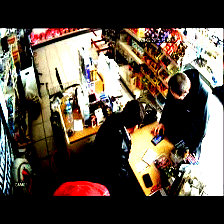

In [3]:
val_generator = DataGenerator_past(directory='/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset_npy_224/val',
                              batch_size=1, 
                              data_augmentation=False)


video = val_generator[217]
# video = np.load('/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset_npy/val/NonFight/6Rl7q_kXYbg_0.npy', mmap_mode='r')
# video = np.float32(video)
# video = uniform_sampling(video)
# video = normalize(video)
# video = np.expand_dims(video, 0)

media.show_videos(video[0], codec='gif', fps=30)

In [4]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

/home/ahreumseo/anaconda/envs/tf2/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.11.0-dev20220813). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [5]:
model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=600,
    output_states=True)

# # # Create your example input here.
# # # Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 8, 172, 172, 3])

# # # [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)
# model.build(video[0].shape)

checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()


# Split the video into individual frames.
# Note: we can also split into larger clips as well (e.g., 8-frame clips).
# Running on larger clips will slightly reduce latency overhead, but
# will consume more memory.
frames = tf.split(video[0], video[0].shape[1], axis=1)

# Initialize the dict of states. All state tensors are initially zeros.
init_states = model.init_states(tf.shape(video[0]))

# Run the model prediction by looping over each frame.
states = init_states
predictions = []
for frame in frames:
  output, states = model({**states, 'image': frame})
  predictions.append(output)

logits = tf.concat(predictions, 0)
probs = tf.nn.softmax(logits)



# The video classification will simply be the last output of the model.
final_prediction = tf.argmax(predictions[-1], -1)

# Alternatively, we can run the network on the entire input video.
# The output should be effectively the same
# (but it may differ a small amount due to floating point errors).
# non_streaming_output, _ = model({**init_states, 'image': inputs})
# non_streaming_prediction = tf.argmax(non_streaming_output, -1)

In [6]:
model.summary()

Model: "movinet_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, None, None,  0           []                               
                                 None, 3)]                                                        
                                                                                                  
 state_block0_layer0_pool_buffe  [(None, 1, 1, 1, 24  0          []                               
 r (InputLayer)                 )]                                                                
                                                                                                  
 state_block0_layer0_pool_frame  [(None,)]           0           []                               
 _count (InputLayer)                                                             

                                                                                                  
 state_block3_layer2_pool_buffe  [(None, 1, 1, 1, 18  0          []                               
 r (InputLayer)                 4)]                                                               
                                                                                                  
 state_block3_layer2_pool_frame  [(None,)]           0           []                               
 _count (InputLayer)                                                                              
                                                                                                  
 state_block3_layer2_stream_buf  [(None, 2, None, No  0          []                               
 fer (InputLayer)               ne, 184)]                                                         
                                                                                                  
 state_blo

                                one, 56),                         'state_block2_layer1_pool_frame_
                                 'block3_layer3': (              count[0][0]',                    
                                None, None, None, N               'state_block2_layer1_stream_buff
                                one, 56),                        er[0][0]',                       
                                 'block4_layer0': (               'state_block2_layer2_pool_buffer
                                None, None, None, N              [0][0]',                         
                                one, 104),                        'state_block2_layer2_pool_frame_
                                 'block4_layer1': (              count[0][0]',                    
                                None, None, None, N               'state_block2_layer2_stream_buff
                                one, 104),                       er[0][0]',                       
          

                                None, 184),                                                       
                                 'state_block2_laye                                               
                                r2_pool_buffer': (N                                               
                                one, None, 1, 1, 18                                               
                                4),                                                               
                                 'state_block2_laye                                               
                                r2_pool_frame_count                                               
                                ': (None,),                                                       
                                 'state_block3_laye                                               
                                r0_stream_buffer':                                                
          

                                ': (None,),                                                       
                                 'state_head_pool_b                                               
                                uffer': (None, 1, 1                                               
                                , 1, 480),                                                        
                                 'state_head_pool_f                                               
                                rame_count': (None,                                               
                                )})                                                               
                                                                                                  
 classifier_head (ClassifierHea  (None, 600)         2214488     ['movinet[0][15]']               
 d)                                                                                               
          

In [7]:
plot_video = plot_streaming_top_preds(probs, video[0][0], video_fps=30.)

 69%|██████▉   | 44/64 [00:19<00:09,  2.04it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100%|██████████| 64/64 [00:28<00:00,  2.24it/s]


In [65]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=30)

## Fine tuning

In [6]:
batch_size = 1
train_generator = DataGenerator_past(directory='/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset_npy_224/train', 
                                batch_size=batch_size, 
                                data_augmentation=True)

val_generator = DataGenerator_past(directory='/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset_npy_224/val',
                              batch_size=batch_size, 
                              data_augmentation=False)

Found 1600 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


In [90]:
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
use_positional_encoding

False

In [8]:
backbone = movinet.Movinet(
	model_id=model_id,
	causal=True,
	conv_type='2plus1d',
	se_type='2plus3d',
	activation='hard_swish',
	gating_activation='hard_sigmoid',
	use_positional_encoding=use_positional_encoding,
	use_external_states=True,
)
model = movinet_model.MovinetClassifier(
	backbone,
	num_classes=600,
	output_states=True)
model.build([1, 1, 1, 1, 3])

In [9]:
checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

In [10]:
def build_classifier(backbone, num_classes, freeze_backbone=False):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes,
      output_states=True)
#   model.build([batch_size, num_frames, resolution, resolution, 3])
  model.build([1, 64, 224, 224, 3])

  if freeze_backbone:
    for layer in model.layers[:-1]:
      layer.trainable = False
    model.layers[-1].trainable = True

  return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.
model = build_classifier(backbone, num_classes=2, freeze_backbone=False)

In [139]:
frames = tf.split(video[0], video[0].shape[1], axis=1)

# Initialize the dict of states. All state tensors are initially zeros.
init_states = model.init_states(tf.shape(video[0]))

# Run the model prediction by looping over each frame.
states = init_states
predictions = []
for frame in frames:
  output, states = model({**states, 'image': frame})
  predictions.append(output)

logits = tf.concat(predictions, 0)
probs = tf.nn.softmax(logits)

In [151]:
final_prediction = tf.argmax(predictions[-1], -1)

# Alternatively, we can run the network on the entire input video.
# The output should be effectively the same
# (but it may differ a small amount due to floating point errors).
non_streaming_output, _ = model({**states, 'image': video[0]})
non_streaming_prediction = tf.argmax(non_streaming_output, -1)

In [11]:
loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=10,
)
optimizer = tf.keras.optimizers.RMSprop(
    initial_learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)
# optimizer = tf.keras.optimizers.Adam(initial_learning_rate)


callbacks = [
    tf.keras.callbacks.TensorBoard(),
    tf.keras.callbacks.ModelCheckpoint(filepath='./rwf-2000_a0_scratch', monitor="val_accuracy", mode="max", save_freq="epoch", save_best_only=True)
]

# model = tf.keras.models.load_model('./rwf-2000_a4')
# model.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

In [122]:
model.backbone.layers[-2].weights

[<tf.Variable 'block4_layer3/bneck/expansion/conv2d/bn/gamma:0' shape=(344,) dtype=float32, numpy=
 array([1.8328892 , 1.3163081 , 1.3916415 , 2.1262138 , 1.2854759 ,
        0.19434397, 1.8666555 , 1.2064186 , 2.0286489 , 1.9041206 ,
        1.290229  , 1.847768  , 0.19494142, 0.9146763 , 1.7191453 ,
        1.9921657 , 1.9064088 , 0.49062887, 1.2424005 , 0.9707821 ,
        2.0530705 , 1.8743035 , 0.191041  , 1.5240256 , 1.9628972 ,
        1.8026725 , 0.8021832 , 1.68139   , 1.9403025 , 0.2654631 ,
        2.4147599 , 1.841952  , 2.1286964 , 1.5112802 , 0.8677746 ,
        0.9633201 , 0.23755278, 1.8191504 , 1.5564866 , 1.0012699 ,
        0.58011687, 1.1728524 , 1.7563605 , 1.0467895 , 1.1582485 ,
        1.3745586 , 1.564456  , 1.2535172 , 2.009614  , 2.053476  ,
        1.9448947 , 1.7200692 , 0.2726674 , 1.6126537 , 2.1414328 ,
        1.1587805 , 1.662553  , 1.7421695 , 0.7091075 , 1.5233696 ,
        0.23922957, 0.906149  , 0.6078543 , 0.28652057, 1.7960117 ,
        1.8846015

In [113]:
import time 

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
train_acc_metric  = tf.keras.metrics.CategoricalAccuracy(name='accuracy', dtype=None)
val_acc_metric  = tf.keras.metrics.CategoricalAccuracy(name='accuracy', dtype=None)


epochs = 5
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_generator):
        with tf.GradientTape() as tape:
            logits, states = model({**states, 'image': x_batch_train}, training=True)  # Logits for this minibatch
            loss_value = loss_fn(y_batch_train, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Update training metric.
        print(y_batch_train, logits)
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
            
            

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_generator:
        val_logits, states = model({**states, 'image': x_batch_val}, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
        break
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
[[1. 0.]] tf.Tensor([[ 2.2689795 -2.3683157]], shape=(1, 2), dtype=float32)
Training loss (for one batch) at step 0: 0.0096
Seen so far: 1 samples
[[1. 0.]] tf.Tensor([[ 2.3256538 -2.4260225]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.3773649 -2.4786782]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.424691  -2.5267992]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.4679203 -2.57075  ]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.5075157 -2.6110358]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.5438879 -2.648016 ]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.5766346 -2.6813195]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.6073136 -2.7125015]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.635443  -2.7410588]], shape=(1, 2), dtype=float32)
[[1. 0.]] tf.Tensor([[ 2.6612532 -2.7673097]], shape=(1, 2), dtype=float32)
Training loss (for one batch) at step 10: 0.0044
Seen so far: 11 samples
[[

KeyboardInterrupt: 

In [108]:
tf.keras.metrics.CategoricalAccuracy()([1,0],[0,0.1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [80]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        print(x.shape)
        with tf.GradientTape() as tape:
#             y_pred = self(x, training=True)  # Forward pass
            logits, status = self(x, training=True)
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            y_pred = tf.argmax(logits, -1)
            print(y_pred)
#             loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            loss = self.compiled_loss(y, logits)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, logits)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [81]:
inputs = tf.keras.Input(shape=(None, None, None, 3))
outputs, status = model({**states, 'image': inputs})
model_v = CustomModel(inputs, outputs)
model_v.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

In [82]:
model_v.fit(train_generator, epochs=1)

(None, None, None, None, None)


OperatorNotAllowedInGraphError: in user code:

    File "/home/ahreumseo/anaconda/envs/tf2/lib/python3.8/site-packages/keras/engine/training.py", line 1177, in train_function  *
        return step_function(self, iterator)
    File "/home/ahreumseo/anaconda/envs/tf2/lib/python3.8/site-packages/keras/engine/training.py", line 1161, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ahreumseo/anaconda/envs/tf2/lib/python3.8/site-packages/keras/engine/training.py", line 1150, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_31541/3740142500.py", line 9, in train_step
        logits, status = self(x, training=True)

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


In [89]:
len(train_generator)

1600

In [7]:
batch_size = 1
train_generator = DataGenerator_past(directory='/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset_npy_224/train', 
                                batch_size=batch_size, 
                                data_augmentation=True)

val_generator = DataGenerator_past(directory='/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset_npy_224/val',
                              batch_size=batch_size, 
                              data_augmentation=False)

Found 1600 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


In [8]:
model_id = 'a0'

tf.keras.backend.clear_session()

# Create backbone and model.
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
backbone = movinet.Movinet(
	model_id=model_id,
	causal=True,
	conv_type='2plus1d',
	se_type='2plus3d',
	activation='hard_swish',
	gating_activation='hard_sigmoid',
	use_positional_encoding=use_positional_encoding,
	use_external_states=True,
)

# Create a movinet classifier using this backbone.
model = movinet_model.MovinetClassifier(
	backbone,
	num_classes=600,
	output_states=True)

2022-10-07 15:50:30.622607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-07 15:50:30.622668: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-07 15:50:30.623200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
movinet_hub_url = f'https://tfhub.dev/tensorflow/movinet/{model_id}/stream/kinetics-600/classification/3'

movinet_hub_model = hub.KerasLayer(movinet_hub_url, trainable=True)

pretrained_weights = {w.name: w for w in movinet_hub_model.weights}

model_weights = {w.name: w for w in model.weights}

for name in pretrained_weights:
# 	model_weights[name].assign(pretrained_weights[name])
    for w in model.weights:
        if name == w.name:
            w.assign(pretrained_weights[name])
            break
        else:
            continue

In [10]:
model = movinet_model.MovinetClassifier(
	backbone=backbone,
	num_classes=2,
	output_states=True)

In [11]:
model.summary()

Model: "movinet_classifier_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, None, None,  0           []                               
                                 None, 3)]                                                        
                                                                                                  
 state_block0_layer0_pool_buffe  [(None, 1, 1, 1, 24  0          []                               
 r (InputLayer)                 )]                                                                
                                                                                                  
 state_block0_layer0_pool_frame  [(None,)]           0           []                               
 _count (InputLayer)                                                           

                                                                                                  
 state_block3_layer2_pool_buffe  [(None, 1, 1, 1, 18  0          []                               
 r (InputLayer)                 4)]                                                               
                                                                                                  
 state_block3_layer2_pool_frame  [(None,)]           0           []                               
 _count (InputLayer)                                                                              
                                                                                                  
 state_block3_layer2_stream_buf  [(None, 2, None, No  0          []                               
 fer (InputLayer)               ne, 184)]                                                         
                                                                                                  
 state_blo

                                one, 56),                         'state_block2_layer1_pool_frame_
                                 'block3_layer3': (              count[0][0]',                    
                                None, None, None, N               'state_block2_layer1_stream_buff
                                one, 56),                        er[0][0]',                       
                                 'block4_layer0': (               'state_block2_layer2_pool_buffer
                                None, None, None, N              [0][0]',                         
                                one, 104),                        'state_block2_layer2_pool_frame_
                                 'block4_layer1': (              count[0][0]',                    
                                None, None, None, N               'state_block2_layer2_stream_buff
                                one, 104),                       er[0][0]',                       
          

                                None, 184),                                                       
                                 'state_block2_laye                                               
                                r2_pool_buffer': (N                                               
                                one, None, 1, 1, 18                                               
                                4),                                                               
                                 'state_block2_laye                                               
                                r2_pool_frame_count                                               
                                ': (None,),                                                       
                                 'state_block3_laye                                               
                                r0_stream_buffer':                                                
          

                                ': (None,),                                                       
                                 'state_head_pool_b                                               
                                uffer': (None, 1, 1                                               
                                , 1, 480),                                                        
                                 'state_head_pool_f                                               
                                rame_count': (None,                                               
                                )})                                                               
                                                                                                  
 classifier_head_1 (ClassifierH  (None, 2)           989186      ['movinet[1][15]']               
 ead)                                                                                             
          

In [19]:
frames = tf.split(video, video.shape[1], axis=1)
frames[0].shape

TensorShape([1, 1, 224, 224, 3])

In [20]:
# model = movinet_model.MovinetClassifier(
#     backbone,
#     num_classes=600,
#     output_states=True)

# # # Create your example input here.
# # # Refer to the paper for recommended input shapes.
# inputs = tf.ones([1, 8, 172, 172, 3])

# # # [Optional] Build the model and load a pretrained checkpoint.
# model.build(inputs.shape)
model.build(video.shape)

# checkpoint_dir = 'movinet_a0_stream'
# checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint = tf.train.Checkpoint(model=model)
# status = checkpoint.restore(checkpoint_path)
# status.assert_existing_objects_matched()


# Split the video into individual frames.
# Note: we can also split into larger clips as well (e.g., 8-frame clips).
# Running on larger clips will slightly reduce latency overhead, but
# will consume more memory.
frames = tf.split(video, video.shape[1], axis=1)

# Initialize the dict of states. All state tensors are initially zeros.
init_states = model.init_states(tf.shape(video))

# Run the model prediction by looping over each frame.
states = init_states
predictions = []
for frame in frames:
  output, states = model({**states, 'image': frame})
  predictions.append(output)

logits = tf.concat(predictions, 0)
probs = tf.nn.softmax(logits)



# The video classification will simply be the last output of the model.
final_prediction = tf.argmax(predictions[-1], -1)

# Alternatively, we can run the network on the entire input video.
# The output should be effectively the same
# (but it may differ a small amount due to floating point errors).
# non_streaming_output, _ = model({**init_states, 'image': inputs})
# non_streaming_prediction = tf.argmax(non_streaming_output, -1)

In [21]:
non_streaming_output, _ = model({**init_states, 'image': video})
non_streaming_prediction = tf.argmax(non_streaming_output, -1)

In [22]:
non_streaming_prediction

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [23]:
# Input layer for the frame sequence
image_input = tf.keras.layers.Input(
    shape=[None, None, None, 3],
    dtype=tf.float32,
    name='image')

# Input layers for the different model states.
# init_states_fn = movinet_hub_model.resolved_object.signatures['init_states']
# init_states = model.init_states([0, 0, 0, 0, 3])
init_states = model.init_states(tf.shape(video))

# state_shapes = {
#     name: ([s if s > 0 else None for s in state.shape], state.dtype)
#     for name, state in init_states_fn(tf.constant([0, 0, 0, 0, 3])).items()
# }

state_shapes = {
    name: ([s if s > 0 else None for s in state.shape], state.dtype)
    for name, state in init_states.items()
}

states_input = {
    name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
    for name, (shape, dtype) in state_shapes.items()
}

# Wrap the Movinet model in a Keras model so that it can be finetuned.

inputs = {**states_input, 'image': image_input}
# inputs = {**init_states, 'image': image_input}

outputs = model(inputs)

In [28]:
# This custom training step ignores the updated states during training as they are only important during inference.
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            pred, states = self({**init_states, 'image': x}, training=True)  # Forward pass
            print(pred)

            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, pred)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred, states = self({**init_states, 'image': x}, training=True)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
    
    
model2 = CustomModel(inputs, outputs, name='movinet')

In [29]:
for layer in model2.layers[:-1]:
	layer.trainable = True
model2.layers[-1].trainable = True

In [30]:
## Training methods
loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=10,
)
optimizer = tf.keras.optimizers.RMSprop(
    initial_learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)


model2.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

In [ ]:
model2.fit(train_generator, validation_data=val_generator, epochs=1)

Tensor("movinet/movinet_classifier_1/classifier_head_1/squeeze3d_1/Squeeze:0", shape=(None, 2), dtype=float32)
Tensor("movinet/movinet_classifier_1/classifier_head_1/squeeze3d_1/Squeeze:0", shape=(None, 2), dtype=float32)
  65/1600 [>.............................] - ETA: 40:52 - loss: 0.7106 - movinet_classifier_1_loss: 0.7106 - movinet_classifier_1_accuracy: 0.5846

In [52]:
({**init_states, 'image': frame_sequence}, label)

NameError: name 'frame_sequence' is not defined